In [19]:
import xml.dom.minidom
import re
import nltk
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pylab as plt
import pandas as pd
import json
import os
import pickle
import math
import numpy as np
from PIL import Image

# Wordclouds

In order to have an easier to read code, we decided to write most of the code inside of function to avoid having redudant code.

## Extracting tokens

Each file is formated in XML and need to be parsed properly before we can exploit it. So we used an XML parser and retrieved every content of type "text".

Because text can be subtitle be also random spaces and line breaker, we used regexps to remove undesired strings. This includes removing non alphanumeric characters like dates and enumerator which could distort our results.

After processing our strings, we removed stopwords from the NLTK library which allowed us to only have relevant words instead of linking words like "be", "I" etc.

Finally, to have homogeneous data, we convert every words to lower case.

In [2]:
def tokenExtractor(file):
    data = open(file, encoding="utf-8").read()

    doc = xml.dom.minidom.parse(file)

    movieText = ""

    #Retrieving data from the file
    for item in doc.getElementsByTagName("s"):
        for child in item.childNodes:
            if child.nodeName == "#text" and len(re.findall("\w", child.nodeValue)) > 1:
                movieText += child.nodeValue

    #Removing undesired strings
    movieText = re.sub("\n\s+", " ", movieText)
    movieText = re.sub("\n", "", movieText)

    pattern = r'''(?x)(?:[A-Z]\.)+ | \w+(?:-\w+)*  | '''
    tokens = nltk.regexp_tokenize(movieText, pattern)

    #Remove non alphanumeric characters
    tokens = [w for w in tokens if re.search(r'\w', w)]

    #Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if w.lower() not in stopwords]

    #Remove numbers 
    tokens = [w for w in tokens if not re.search(r'\d', w)]

    #Lower case
    tokens = [t.lower() for t in tokens]
    tokens = [item for item in tokens if item.isalpha()]
    
    return tokens

## Metadata

In order to have a list of every movie we would want to process, we had to use this metadata file from kaggle. This file is a modified version of the original one because it doesn't include movie with less that 500 total votes. We had to cut down to this number to we could calculate the graph first.

In [ ]:
def loadData():
    metadata_file = "movies_metadata.csv"
    genre_set = {""}

    metadata_data = pd.read_csv(metadata_file, encoding ='utf-8')
    for genre_list in metadata_data["genres"]:
        genre_list = genre_list.replace("'", '"')
        genre_json = json.loads(genre_list)
        for genre in genre_json:
            genre_set.add(genre["name"])
    
    return genre_set, metadata_data

## Genres

To determine the genre a movie belongs too, we had to read a JSON string inside of the metadata file described earlier and compare each genre to the desired genre given as parameter.

In [3]:
def has_genre(genre, movie_data):
    genres_data = movie_data["genres"].replace("'", '"')
    genres_json = json.loads(genres_data)
    for g_object in genres_json:
        if g_object["name"] == genre:
            return True
    return False

## Generating the token list

Once we extracted tokens from our files, we have to make a list of tokens per genre. In order to do this, we just open each subtitle file where the movie has the specified genre. After we found every tokens for the choosen genre, we just return the token list.

In [5]:
def generateTokensFor(choosen_genre, metadata_data):
    tokens = []

    for index, movie in metadata_data.iterrows():
        if has_genre(choosen_genre, movie):
            if len(str(movie["release_date"]).split("-")[0]) == 4:
                release_date = movie["release_date"].split("-")[0]
                
            movie_id = str(movie["imdb_id"])

            if len(movie_id) > 1:
                while movie_id[0] == 't' or movie_id[0] == '0' :
                    movie_id = movie_id[1:]

            movieDir = "/Subs/en/{}/{}".format(release_date, movie_id)

            try:
                files = os.listdir(movieDir)
                movie_file = movieDir + '/' + files[0]

                tokens = tokens + tokenExtractor(movie_file)
            except:
                # print("Cannot find file " + movieDir)
                pass
                
    return tokens

## Performance issues

Because of performance issues, we had to process each genre one by one. So we had to create a list (below) that contained every genre already processed and what we had left. Some genre throw errors because they only contain one movie which is not correctly informed so they can't be processed properly.

In [6]:
genres, data = loadData()

#Processed list
genres.remove("")
genres.remove("Horror")
genres.remove("Foreign")
genres.remove("Music")
genres.remove("Action")
genres.remove("Adventure")
genres.remove("Animation")
genres.remove("Aniplex") # Error
genres.remove("BROSTA TV") # Error
genres.remove("Carousel Productions") # Error
genres.remove("Comedy")
genres.remove("Crime")
genres.remove("Documentary")
genres.remove("Drama")
genres.remove("Family")
genres.remove("Fantasy")
genres.remove("GoHands") # Error
genres.remove("Mardock Scramble Production Committee") # Error
genres.remove("Odyssey Media") # Error
genres.remove("Pulser Productions") # Error
genres.remove("History") 
genres.remove("Mystery")
genres.remove("Romance")
genres.remove("Rogue State") # Error
genres.remove("Sentai Filmworks") # Error
genres.remove("Telescene Film Group Productions") # Error
genres.remove("The Cartel") # Error
genres.remove("Vision View Entertainment") # Error
genres.remove("Science Fiction")
genres.remove("TV Movie")
genres.remove("Thriller")
genres.remove("War")
genres.remove("Western")
genres

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


set()

The corresponding lines of code for processing each genre.

In [34]:
genres_tokens = {}

genres_tokens["Science Fiction"] = generateTokensFor("Science Fiction", data)
print("done Science Fiction")
genres_tokens["TV Movie"] = generateTokensFor("TV Movie", data)
print("done TV Movie")
genres_tokens["Thriller"] = generateTokensFor("Thriller", data)
print("done Thriller")
genres_tokens["War"] = generateTokensFor("War", data)
print("done War")
genres_tokens["Western"] = generateTokensFor("Western", data)
print("done Western")

done Science Fiction
done TV Movie
done Thriller
done War
done Western


In order to ease our workflow, we decided to use pickle to save and load files from different coding sessions.

In [35]:
pickle_file = open("genres_tokens_scifi-tvmovie-thriller-war-western.backup", "wb")

pickle.dump(genres_tokens, pickle_file)

pickle_file.close()

A little sound is always a nice thing to have when you need to know when your long lasting code is done.

In [36]:
from IPython.display import Audio
Audio('../alert.wav', autoplay=True) # load a local WAV file

In [7]:
#nbWords is a dict of the number of iteration of each word, for example [{"hello", 3}, {"going", 1}]
#tokens is a list of all the words

def computeTF(nbWords, tokens):
    tfDict = {}
    tokenCount = len(tokens)
    for word, count in nbWords.items():
        tfDict[word] = count / float(tokenCount)
    
    return tfDict

In [8]:
#documents is an array of every dict used as nbWords parameter for the computeTF function

def computeIDF(documents):
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    
    for document in documents:
        for word, val in document.items():
            if val > 0:
                if word in idfDict:
                    idfDict[word] += 1
                else:
                    idfDict[word] = 1
                
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
        
    return idfDict

In [9]:
def getNbUniqueWord(word_list):
    nb_word = {}
    for word in word_list:
        if word in nb_word:
            nb_word[word] += 1
        else:
            nb_word[word] = 1
    
    return nb_word

In [10]:
genres_tokens = {}

# Load pickle files

backup_list = ["genres_tokens_action-adventure-animation.backup", 
               "genres_tokens_comedy-crime-documentary.backup", 
               "genres_tokens_drama-family-fantasy.backup",
               "genres_tokens_foreign-horror-music.backup",
               "genres_tokens_history-mystery-romance.backup",
               "genres_tokens_scifi-tvmovie-thriller-war-western.backup"]

for backup in backup_list:
    print(backup)
    
    pickle_file = open(backup, "rb")
    
    backup_data = pickle.load(pickle_file)

    for genre in backup_data:
        genres_tokens[genre] = backup_data[genre]


genres_tokens_action-adventure-animation.backup
genres_tokens_comedy-crime-documentary.backup
genres_tokens_drama-family-fantasy.backup
genres_tokens_foreign-horror-music.backup
genres_tokens_history-mystery-romance.backup
genres_tokens_scifi-tvmovie-thriller-war-western.backup


In [11]:
uniqueWords = set()

genres_nb_word = {}

for genre in genres_tokens:
    uniqueWords = uniqueWords.union(set(genres_tokens[genre]))
    
    genres_nb_word[genre] = getNbUniqueWord(genres_tokens[genre])

genres_tfs = {}

for genre in genres_tokens:
    
    genres_tfs[genre] = computeTF(genres_nb_word[genre], genres_tokens[genre])
    
nb_word_array = []

for genre in genres_nb_word:
    nb_word_array.append(genres_nb_word[genre])

idfs = computeIDF(nb_word_array)

genres_tfidfs = {}

for genre in genres_tokens:
    tfidf = {}
    
    for word in genres_tfs[genre]:
        tfidf[word] = genres_tfs[genre][word] * idfs[word]
    
    genres_tfidfs[genre] = tfidf

In [13]:
#SAVE TFIDFs WITH PICKLE

pickle_file = open("tfidf.backup", "wb")

pickle.dump(genres_tfidfs, pickle_file)

pickle_file.close()

In [13]:
#LOAD TFIDFs WITH PICKLE

pickle_file = open("tfidf.backup", "rb")

genres_tfidfs = pickle.load(pickle_file)

pickle_file.close()

In [14]:
for genre in genres_tfidfs:
    print(genre)

Action
Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
Fantasy
Foreign
Horror
Music
History
Mystery
Romance
Science Fiction
TV Movie
Thriller
War
Western


In [13]:
wordclouds = {}

for genre in genres_tfidfs:
    wordclouds[genre] = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(genres_tfidfs[genre])

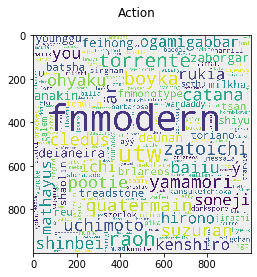

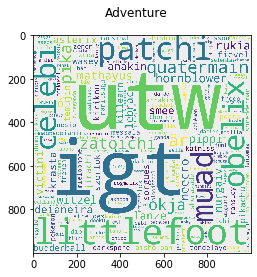

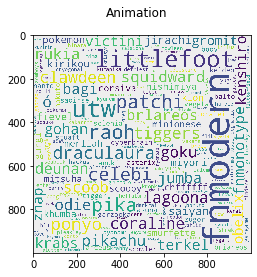

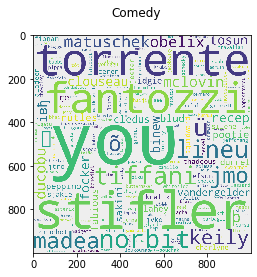

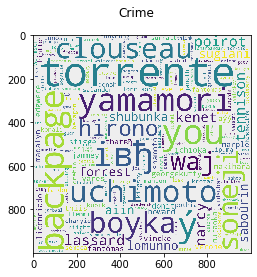

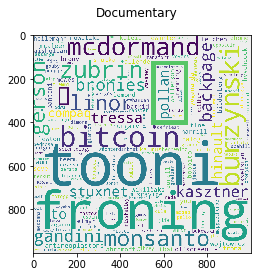

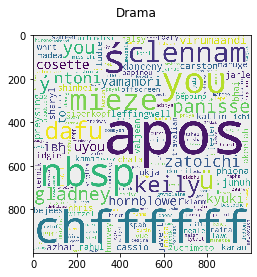

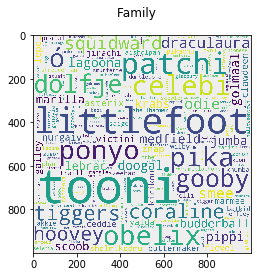

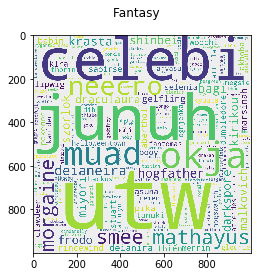

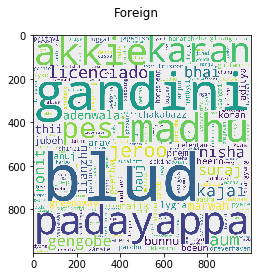

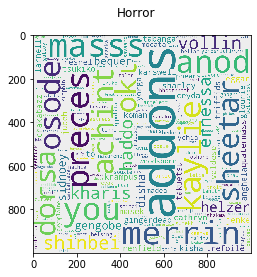

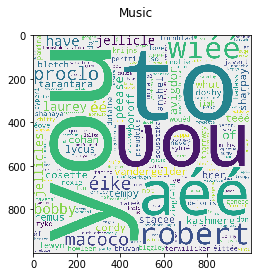

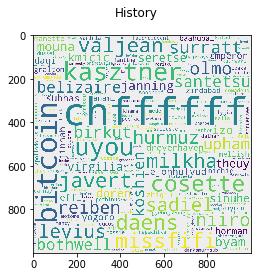

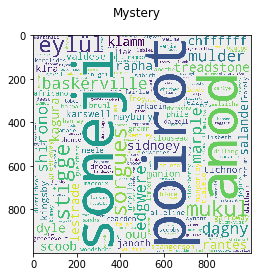

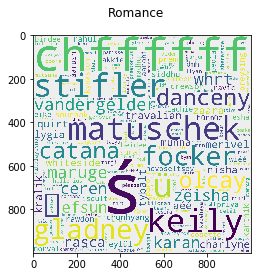

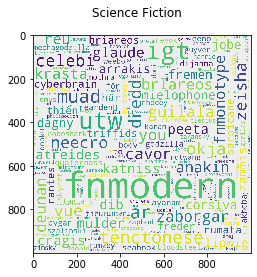

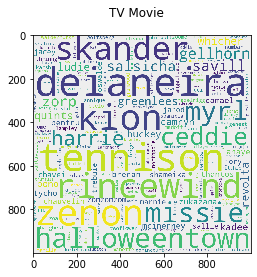

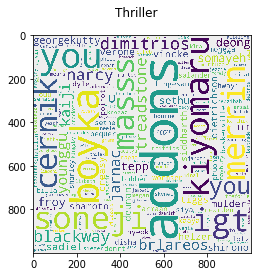

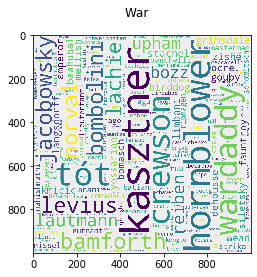

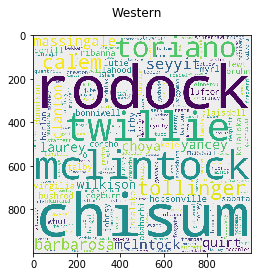

In [19]:
wordcloud_index = 0

for genre in wordclouds:
    plt.figure(wordcloud_index)
    plt.suptitle(genre)
    plt.imshow(wordclouds[genre])
    wordcloud_index += 1

In [56]:
sup_tfidfs = {}

for genre in genres_tfidfs:
    sup = {}
    for word in genres_tfidfs[genre]:
        if "fnm" not in word and word is not "utw":
            sup[word] = genres_tfidfs[genre][word]
    
    sup_tfidfs[genre] = sup

In [82]:
action_wd = WordCloud(width=1920, height=1080, background_color="white", mode="RGBA", max_words=1000, colormap="tab10").generate_from_frequencies(sup_tfidfs["Action"])

In [85]:
for genre in sup_tfidfs:
    wd = WordCloud(width=1920, height=1080, background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000, colormap="tab10").generate_from_frequencies(sup_tfidfs[genre])

    wd.to_file("wordclouds/{}.png".format(genre))